Input variables:
  - 1 - age (numeric)
  - 2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
  - 3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
  - 4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
  - 5 - default: has credit in default? (categorical: "no","yes","unknown")
  - 6 - housing: has housing loan? (categorical: "no","yes","unknown")
  - 7 - loan: has personal loan? (categorical: "no","yes","unknown")
  - 8 - contact: contact communication type (categorical: "cellular","telephone") 
  - 9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  - 10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  - 11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  - 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  - 14 - previous: number of contacts performed before this campaign and for this client (numeric)
  - 15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  - 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  - 17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  - 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  - 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  - 20 - nr.employed: number of employees - quarterly indicator (numeric)
  - 21 - y - has the client subscribed a term deposit? (binary: "yes","no")


## Objective
- menganalisa potensi client yang akan berlangganan deposit dilihat dari beberapa parameter seperti umur, pekerjaan, tingkat pendidikan, dll
- Mencari Model yang terbaik untuk prediksi langganan deposit dari beberapa scoring dan hyperparameter tuning

## Import Library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,\
plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, confusion_matrix, roc_curve, plot_roc_curve, auc
import sklearn
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

### Load Data

In [4]:
data = pd.read_csv("bank-additional-full.csv", sep=";")

In [5]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
data.select_dtypes(object).describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [9]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Tidak terdapat data yang nan, tetapi saya akan melihat apakah ada data yang aneh atau berbeda

In [10]:
for i in data.columns:
    print(f"{[i]} \n {data[i].unique()} \n")

['age'] 
 [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89] 

['job'] 
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

['marital'] 
 ['married' 'single' 'divorced' 'unknown'] 

['education'] 
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

['default'] 
 ['no' 'unknown' 'yes'] 

['housing'] 
 ['no' 'yes' 'unknown'] 

['loan'] 
 ['no' 'yes' 'unknown'] 

['contact'] 
 ['telephone' 'cellular'] 

['month'] 
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

['day_of_week'] 
 ['mon' 'tue' 'wed' 'thu' 'fri'] 

['duration'] 
 [ 261  149  226 ... 1246 1556 1868] 

['campaign'] 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18

Terdapat data yang "Unknown" yang berarti tidak diketahui isi dari data tersebut berupa apa

In [11]:
data.duplicated().any()

True

In [12]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
41183    False
41184    False
41185    False
41186    False
41187    False
Length: 41188, dtype: bool

In [13]:
data[data.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


In [14]:
print( "Jumah Baris Data Duplikat", len(data[data.duplicated()]) , "di Index ke: " ,list(data[data.duplicated()].index))
data[data.duplicated()]

Jumah Baris Data Duplikat 12 di Index ke:  [1266, 12261, 14234, 16956, 18465, 20216, 20534, 25217, 28477, 32516, 36951, 38281]


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,33,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,114,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [15]:
data = data.drop_duplicates(keep='first')
data.reset_index(drop = True, inplace = True)

Terdapat data yang duplikat dari dataset ini, ada 12 baris, dan saya disini menghapus data yang duplikat tadi

In [16]:
data.shape

(41176, 21)

In [17]:
aa = ["job", "marital", "education", "default", "housing", "loan", "poutcome"]
for i in aa:
    print(f"{[i]} \n {data[i].value_counts()} \n")

['job'] 
 admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

['marital'] 
 married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64 

['education'] 
 university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64 

['default'] 
 no         32577
unknown     8596
yes            3
Name: default, dtype: int64 

['housing'] 
 yes        21571
no         18615
unknown      990
Name: housing, dtype: int64 

['loan'] 
 no         33938
yes         6248
unknown      990
Name: loan, dtype: int64 

['poutcome'] 

In [18]:
data["job"] = data["job"].str.replace('.', '', regex = False)
data["education"] = data["education"].str.replace('.', ' ', regex = False)
data["pdays"] = data["pdays"].replace(999, -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Terdapat karakter yang kurang enak dilihat di dataset ini, sehingga saya menggantinya dengan spasi, seperti yang terdapat di kolom education, dan kolom pdays, 999 menunjukan kalau client tersebut belum dihubungi sebelumnya, disini saya ganti dengan nilai -1 saja

In [19]:
num_col = list(data.select_dtypes("number").columns)
cat_col = list(data.select_dtypes("object").columns)

In [20]:
data[num_col]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,-1,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,-1,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,-1,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,-1,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,-1,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41171,73,334,1,-1,0,-1.1,94.767,-50.8,1.028,4963.6
41172,46,383,1,-1,0,-1.1,94.767,-50.8,1.028,4963.6
41173,56,189,2,-1,0,-1.1,94.767,-50.8,1.028,4963.6
41174,44,442,1,-1,0,-1.1,94.767,-50.8,1.028,4963.6


In [21]:
data[cat_col].drop(columns="y", axis=1)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic 4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high school,no,yes,no,telephone,may,mon,nonexistent
3,admin,married,basic 6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high school,no,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...
41171,retired,married,professional course,no,yes,no,cellular,nov,fri,nonexistent
41172,blue-collar,married,professional course,no,no,no,cellular,nov,fri,nonexistent
41173,retired,married,university degree,no,yes,no,cellular,nov,fri,nonexistent
41174,technician,married,professional course,no,no,no,cellular,nov,fri,nonexistent


## EDA

### Categorical Feature

In [22]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

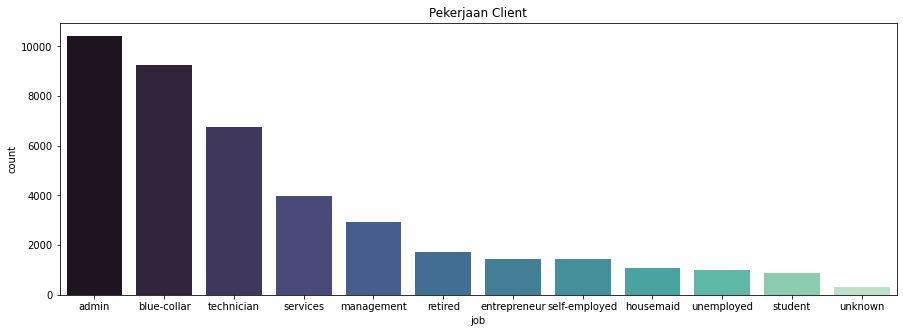

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(x = data["job"], order = data["job"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Pekerjaan Client")
plt.show()

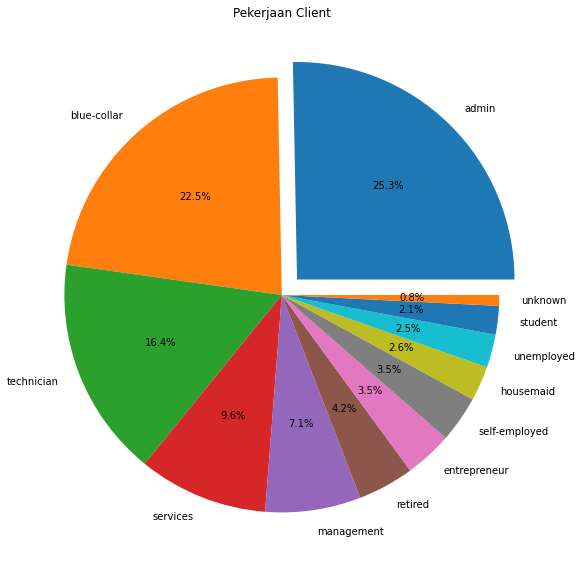

In [24]:
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

plt.figure(figsize = (10,10))
plt.pie(data['job'].value_counts(), labels=data['job'].value_counts().index, explode=explode, autopct='%1.1f%%')
plt.title("Pekerjaan Client")
plt.show()

Dari client yang dihubungi, kebanyakan client tersebut bekerja sebagai admin

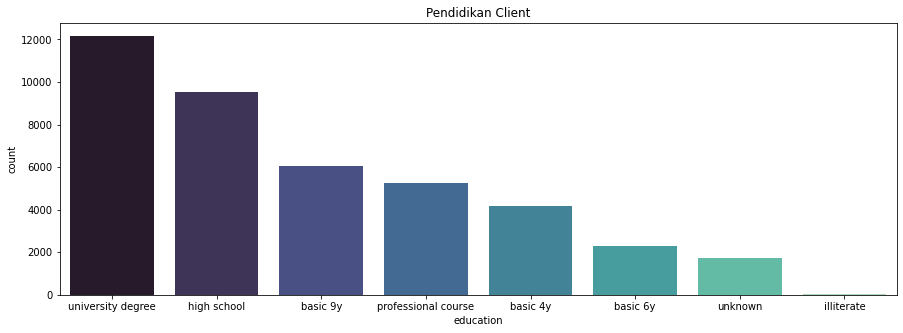

In [25]:
plt.figure(figsize=(15,5))
sns.countplot(x = data["education"], order = data["education"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Pendidikan Client")
plt.show()

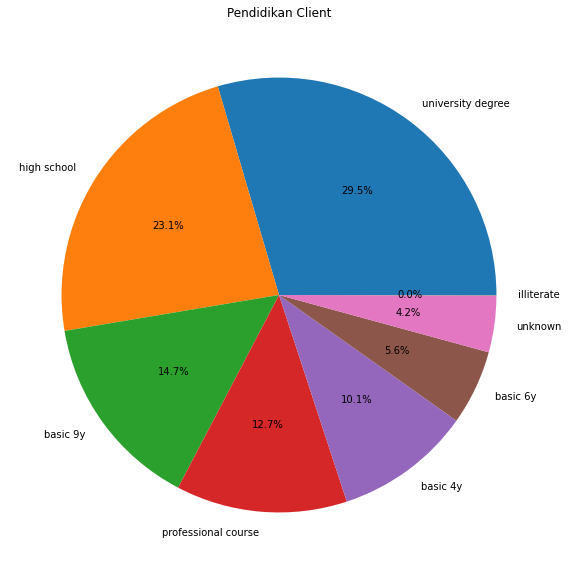

In [26]:
plt.figure(figsize = (10,10))
plt.pie(data['education'].value_counts(), labels=data['education'].value_counts().index, autopct='%1.1f%%')
plt.title("Pendidikan Client")
plt.show()

Client yang dihubungi kebanyakan berpendidikan sebagai lulusan dari universitas

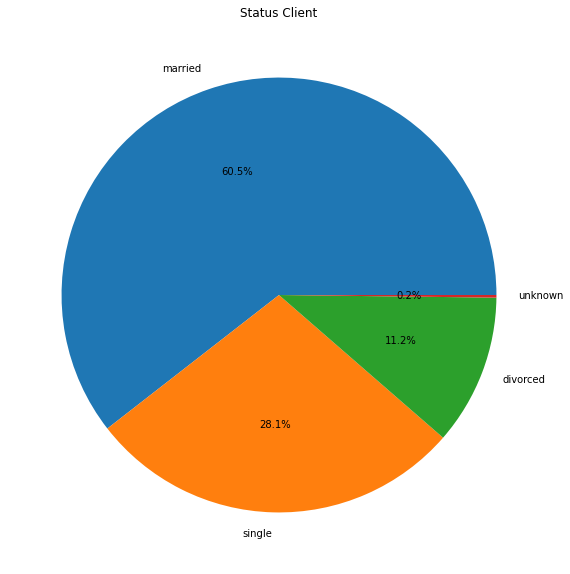

In [27]:
plt.figure(figsize = (15,10))
plt.pie(
    data['marital'].value_counts(),
    labels=data['marital'].value_counts().index,
    autopct='%1.1f%%'
)
plt.title("Status Client")
plt.show()

Sebesar 60% dari client yang dihubungi, kebanyakan berstatus sudah menikah, 28% single dan 11.2% sudah bercerai

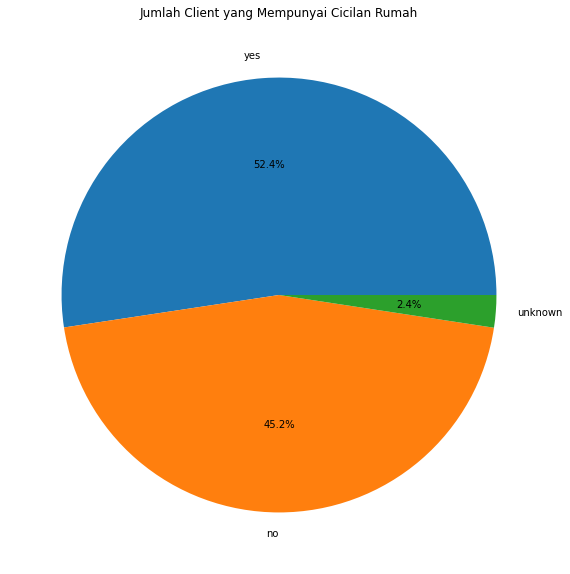

In [28]:
plt.figure(figsize = (10,10))
plt.pie(data['housing'].value_counts(), labels=data['housing'].value_counts().index, autopct='%1.1f%%')
plt.title("Jumlah Client yang Mempunyai Cicilan Rumah")
plt.show()

Rata rata dari client yang dihubungi memiliki cicilan rumah

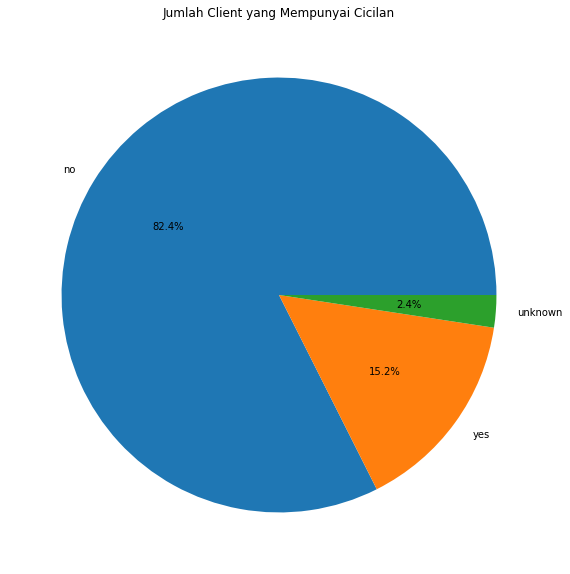

In [29]:
plt.figure(figsize = (10,10))
plt.pie(data['loan'].value_counts(), labels=data['loan'].value_counts().index, autopct='%1.1f%%')
plt.title("Jumlah Client yang Mempunyai Cicilan")
plt.show()

Ada 82.4% client yang tidak memiliki cicilan atau pinjaman lain selain rumah, dan hanya 15.2% yang memiliki pinjaman

In [30]:
data.groupby(data['contact']).sum().campaign.reset_index()

,contact,campaign
0,cellular,62861
1,telephone,42874


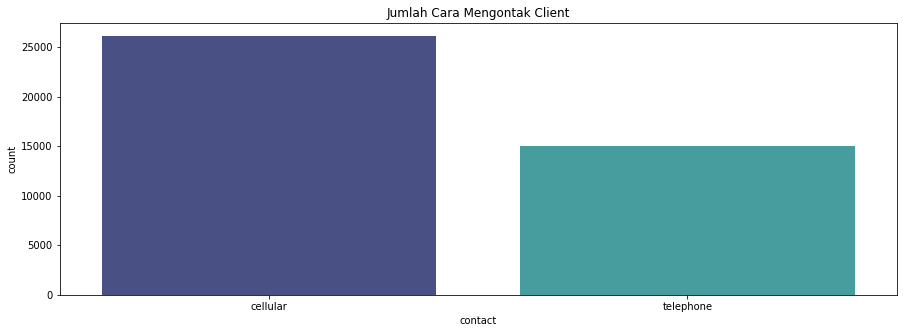

In [31]:
plt.figure(figsize=(15,5))
sns.countplot(x = data["contact"], order = data["contact"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Jumlah Cara Mengontak Client")
plt.show()

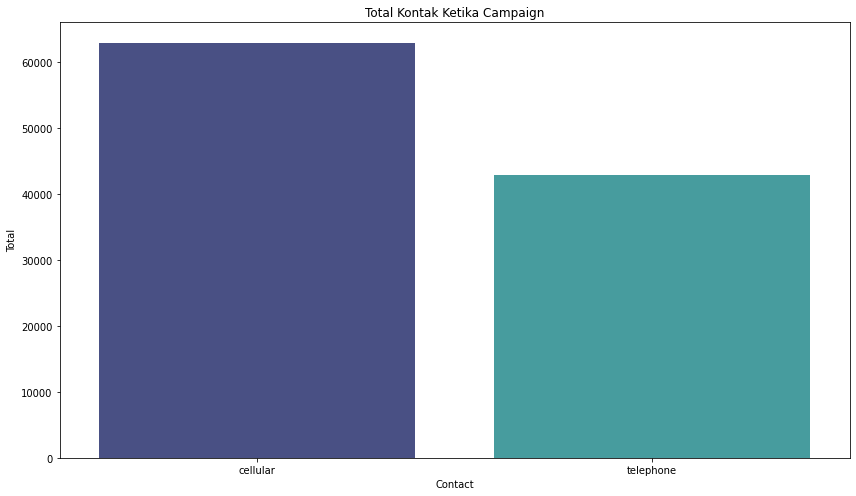

In [32]:
plt.figure(figsize = (12,7))

sns.barplot(x='contact',
            y='campaign',
            data=data.groupby(data['contact']).sum().campaign.reset_index(),
            palette='mako')

plt.ylabel("Total")
plt.xlabel("Contact")
plt.title('Total Kontak Ketika Campaign')

plt.tight_layout()
plt.show()

Kebanyakan client dihubungi dari telepon celuler dibandingkan melalui telepon rumah

In [33]:
data.groupby(data['poutcome']).sum().previous.reset_index()

,poutcome,previous
0,failure,4969
1,nonexistent,0
2,success,2155


Text(0.5, 1.0, 'Outcome dari Campaign Sebelumnya')

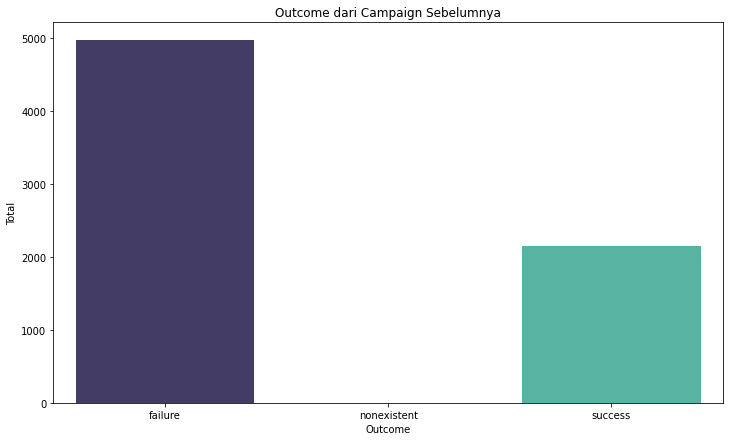

In [34]:
plt.figure(figsize = (12,7))

sns.barplot(
    x='poutcome', 
    y='previous', 
    data=data.groupby(data['poutcome']).sum().previous.reset_index(), 
    palette='mako')

plt.ylabel("Total")
plt.xlabel("Outcome")
plt.title('Outcome dari Campaign Sebelumnya')


Jika dilihat dari campaign sebelumnya, kebanyakan hasil dari campaign sebelumnya gagal, ada sekitar lebih dari setengahnya dari yang berhasil

In [35]:
data["y"].value_counts().sort_values(ascending = False)

no     36537
yes     4639
Name: y, dtype: int64

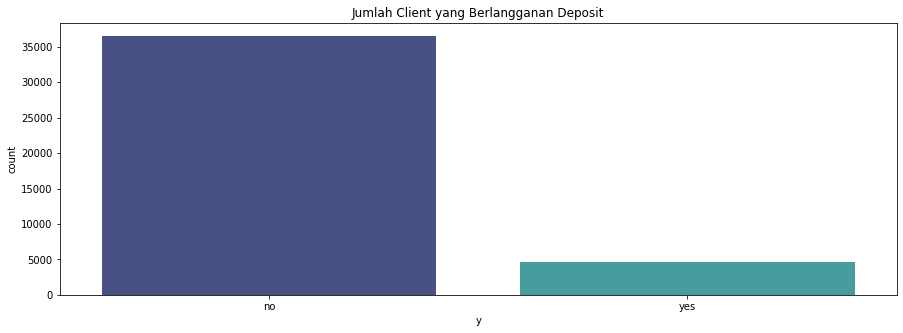

In [36]:
plt.figure(figsize=(15,5))
sns.countplot(x = data["y"], order = data["y"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Jumlah Client yang Berlangganan Deposit")
plt.show()

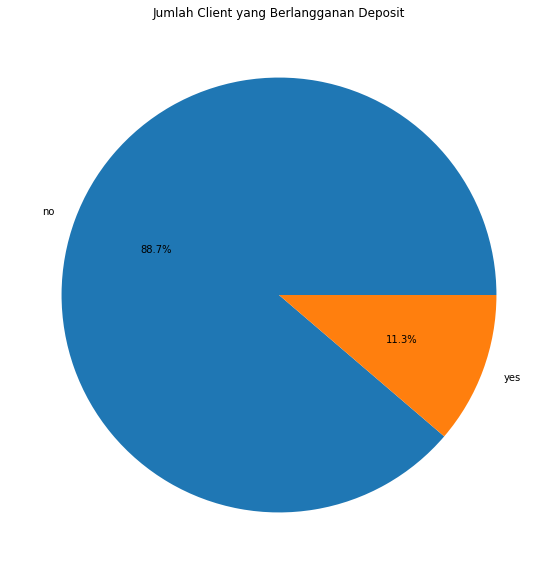

In [37]:
plt.figure(figsize = (10,10))
plt.pie(data['y'].value_counts(), labels=data['y'].value_counts().index, autopct='%1.1f%%')
plt.title("Jumlah Client yang Berlangganan Deposit")
plt.show()

Jumlah client yang akhirnya berlangganan deposit lebih sedikit daripada yang tidak berlangganan

In [38]:
cat_col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
cat_col

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

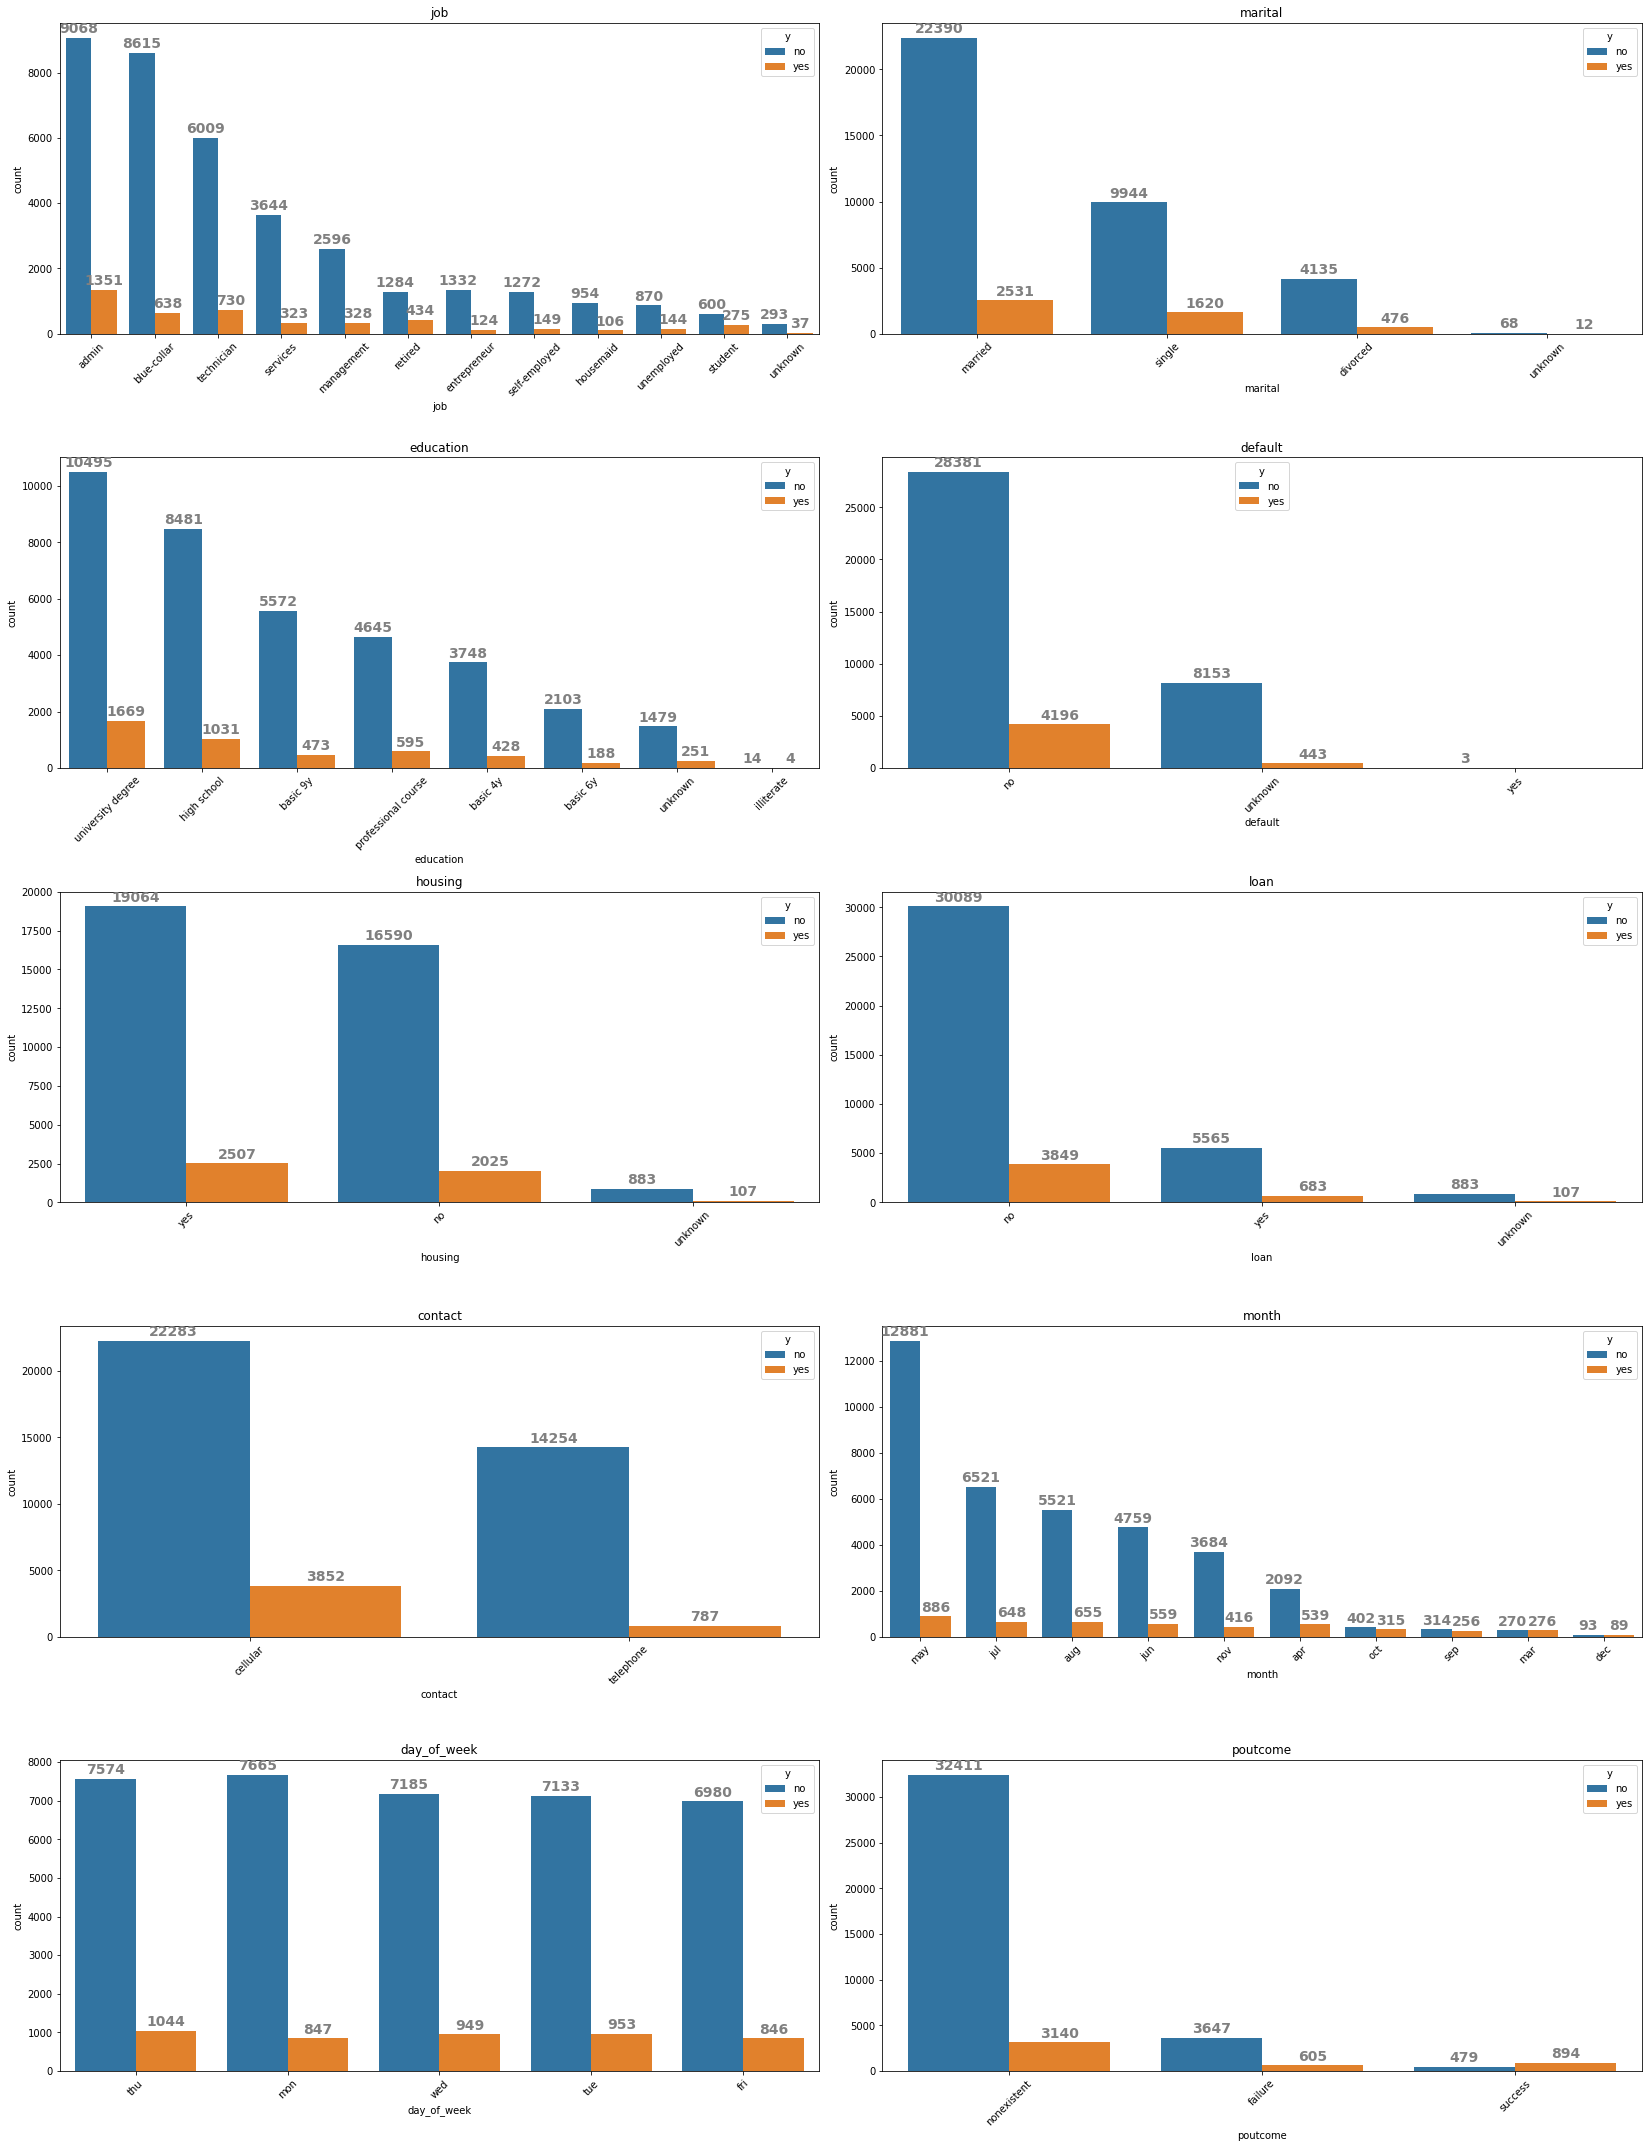

In [39]:
plt.figure(figsize = (23, 35))
for i in range(len(cat_col)):
    plt.subplot(len(cat_col)//2+1, 2, i + 1)
    ax = sns.countplot(
        x = data[cat_col[i]],
        hue = data["y"],
        order = data[cat_col[i]].value_counts().sort_values(ascending = False).index
    )
    for j in ax.patches:
        ax.annotate(
            format(j.get_height(), '.0f'),
            (j.get_x() + j.get_width() / 2., j.get_height()), 
            ha = 'center',
            fontweight = 'semibold',
            size = 14,
            xytext = (0, 5), 
            textcoords = 'offset points',
            color = 'grey'
        )
    plt.title(str(cat_col[i]))
    plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

- Dari beberapa pekerjaan client, admin paling banyak untuk berlangganan deposit, jika dilihat keseluruhan, pekerjaan dengan penghasilan yang "tetap" lebih berpotensi untuk berlangganan daripada pekerjaan dengan penghasilan yang tidak tetap seperti ibu rumah tangga, pensiunan, self employed dll
- Status dari clien yang menikah lebih banyak berlangganan deposit, tetapi untuk client yang single juga berpotensi untuk berlangganan
- Client lulusan Universitas lebih banyak berlangganan deposit.
- Client yang tidak memiliki kartu kredit, lebih banyak berlangganan deposit, mungkin bisa jadi pembayaran kartu kredit ini menghambat seseorang untuk berlangganan deposit
- Client yang tidak memiliki Pinjaman lebih berpotensi untuk berlangganan, dan yang memiliki cicilan rumah juga berpotensi untuk berlangganan deposit

### Numerical Features

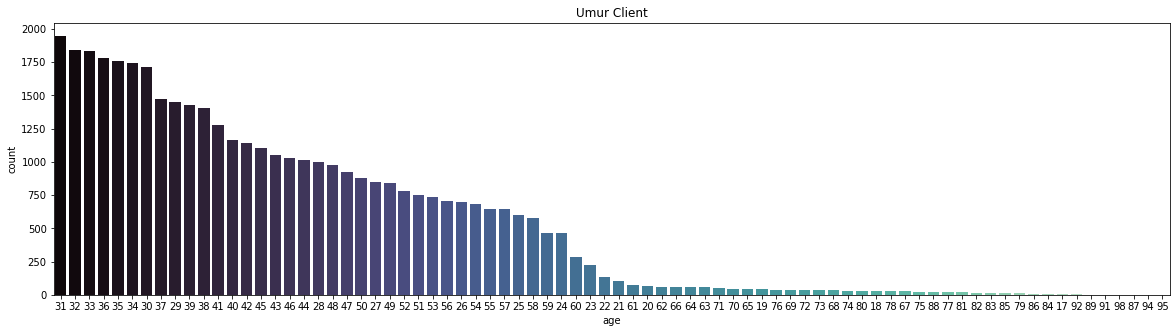

In [40]:
plt.figure(figsize=(20,5))
sns.countplot(x = data["age"], order = data["age"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Umur Client")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


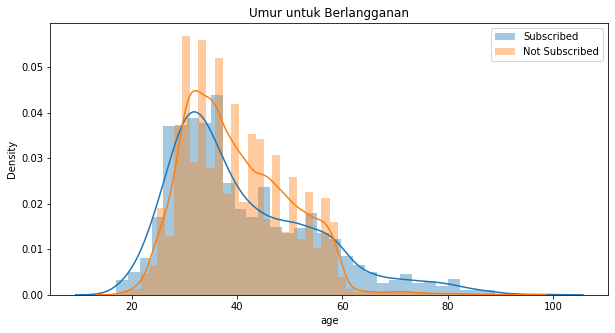

In [41]:
plt.figure(figsize=(10,5))
plt.title('Umur untuk Berlangganan')
sns.distplot(data[data['y'] == 'yes']['age'], label='Subscribed')
sns.distplot(data[data['y'] == 'no']['age'], label='Not Subscribed')
plt.legend(loc= 'upper right')
plt.show()

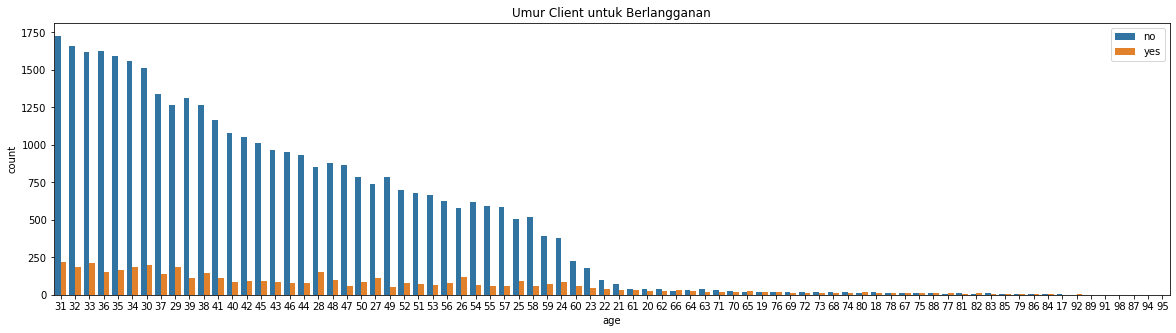

In [42]:
plt.figure(figsize=(20,5))
plt.title('Umur Client untuk Berlangganan')
sns.countplot(
        x = data["age"],
        hue = data["y"],
        order = data["age"].value_counts().sort_values(ascending = False).index
    )
plt.legend(loc= 'upper right')
plt.show()

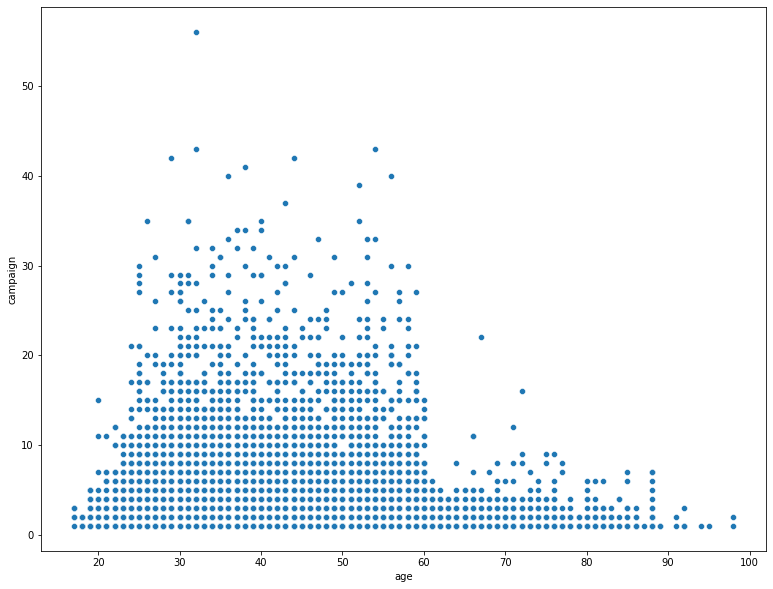

In [43]:
plt.figure(figsize=(13,10))
sns.scatterplot(data=data,x='age',y="campaign")

Client yang dihubungi kebanyakan berumur 24 - 60 tahun, dimana yang berpotensi untuk berlangganan deposit berada di umur 24-45 tahun

> Indented block



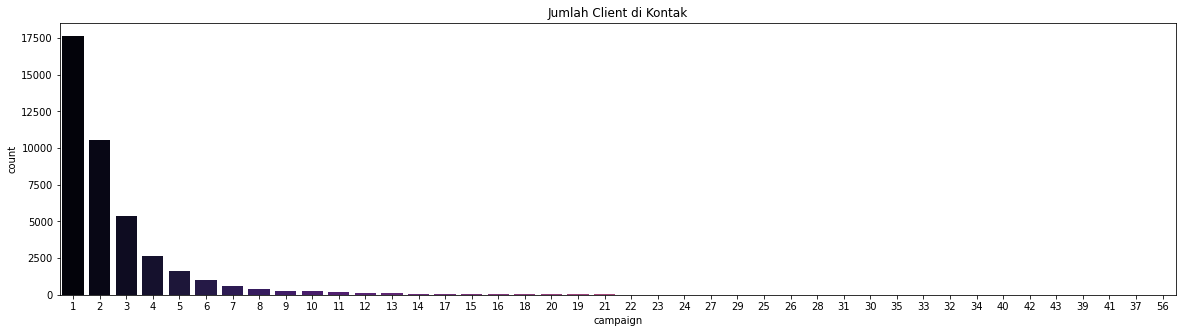

In [44]:
plt.figure(figsize=(20,5))
sns.countplot(x = data["campaign"], order = data["campaign"].value_counts().sort_values(ascending = False).index, palette = "magma")
plt.title("Jumlah Client di Kontak")
plt.show()

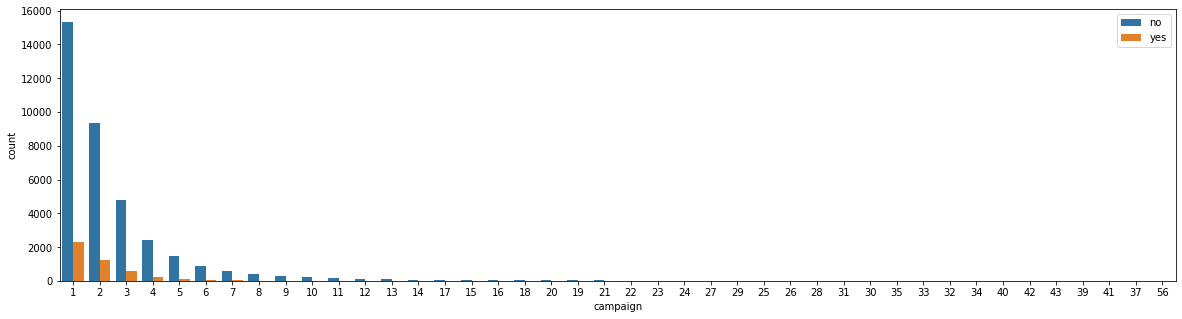

In [45]:
plt.figure(figsize=(20,5))
sns.countplot(
        x = data["campaign"],
        hue = data["y"],
        order = data["campaign"].value_counts().sort_values(ascending = False).index
    )
plt.legend(loc= 'upper right')
plt.show()

Kebanyakan client hanya dihubungi 1 kali, dan kebanyakan yang dihubungi 1 kali langsung berlangganan, makin banyak dihubungi maka peluang berlangganan semakin kecil

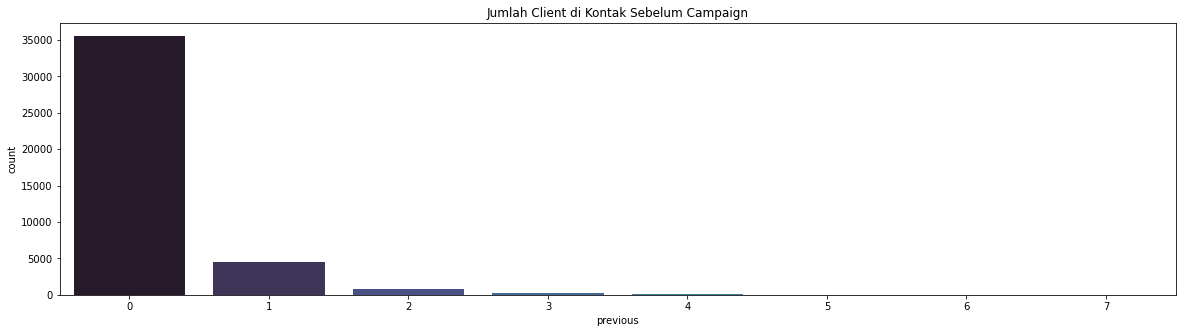

In [46]:
plt.figure(figsize=(20,5))
sns.countplot(x = data["previous"], order = data["previous"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Jumlah Client di Kontak Sebelum Campaign")
plt.show()

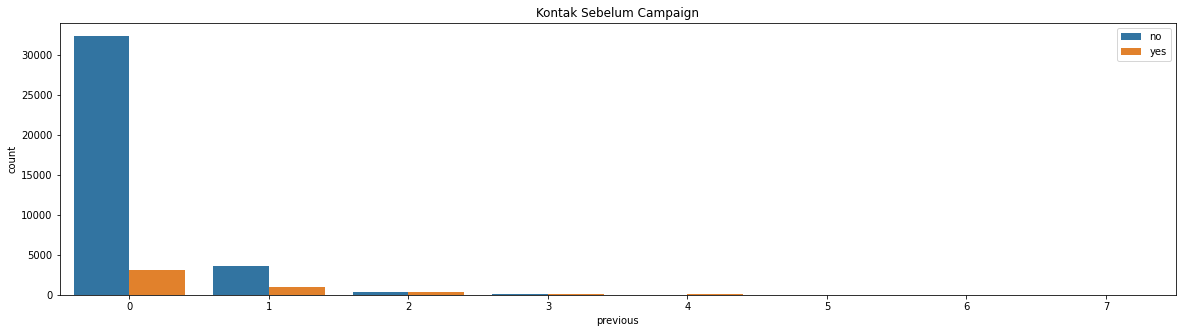

In [47]:
plt.figure(figsize=(20,5))
plt.title('Kontak Sebelum Campaign')
sns.countplot(
        x = data["previous"],
        hue = data["y"],
        order = data["previous"].value_counts().sort_values(ascending = False).index
    )
plt.legend(loc= 'upper right')
plt.show()

Client yang banyak berlangganan biasanya belum dihubungi sebelumnya, atau paling tidak sudah pernah dihubungi sekali sebelumnya

In [48]:
data["pdays"].value_counts().sort_values(ascending = False)

-1     39661
 3       439
 6       412
 4       118
 9        64
 2        61
 7        60
 12       58
 10       52
 5        46
 13       36
 11       28
 1        26
 15       24
 14       20
 8        18
 0        15
 16       11
 17        8
 18        7
 19        3
 22        3
 21        2
 25        1
 27        1
 20        1
 26        1
Name: pdays, dtype: int64

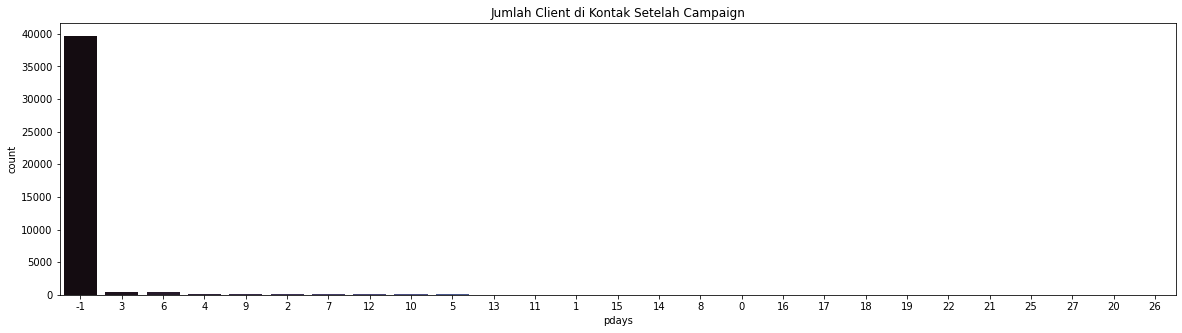

In [49]:
plt.figure(figsize=(20,5))
sns.countplot(x = data["pdays"], order = data["pdays"].value_counts().sort_values(ascending = False).index, palette = "mako")
plt.title("Jumlah Client di Kontak Setelah Campaign")
plt.show()

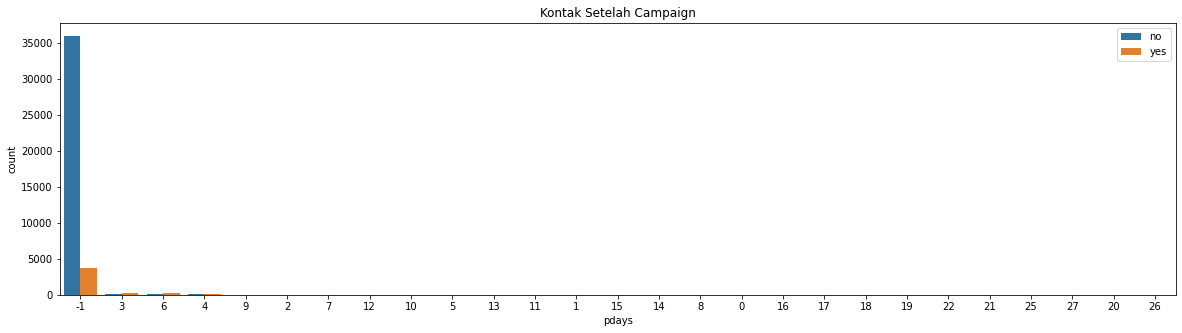

In [50]:
plt.figure(figsize=(20,5))
plt.title('Kontak Setelah Campaign')
sns.countplot(
        x = data["pdays"],
        hue = data["y"],
        order = data["pdays"].value_counts().sort_values(ascending = False).index
    )
plt.legend(loc= 'upper right')
plt.show()

Client yang banyak berlangganan biasanya belum dihubungi atau belum ditawari deposit dari campaign sebelumnya

In [51]:
data["duration"].value_counts().sort_values(ascending = False)

85      170
90      170
136     168
73      167
124     163
       ... 
1776      1
1290      1
1412      1
1606      1
2015      1
Name: duration, Length: 1544, dtype: int64

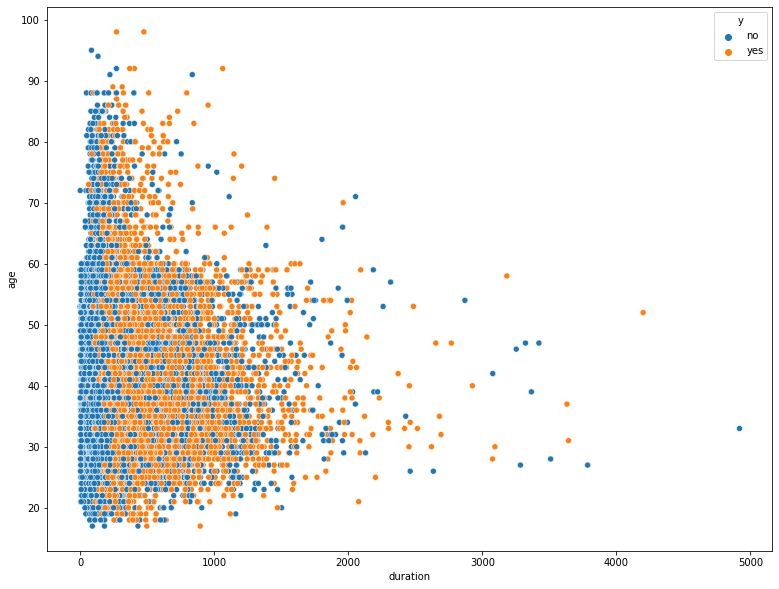

In [52]:
plt.figure(figsize=(13,10))
sns.scatterplot(data=data,x='duration',y="age", hue = 'y')

biasanya client dihubungi sekitar 90-150 detik, jika dilihat dari peta persebaran, makin lama durasi meneleponya maka biasanya client akan berlangganan, dengan durasi yang lama ini maka penjelasan keuntungan berlangganan deposit akan lebih jelas, sehingga dapat menarik minat client untuk berlangganan deposit

### Preprocessing

In [53]:
num_col = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

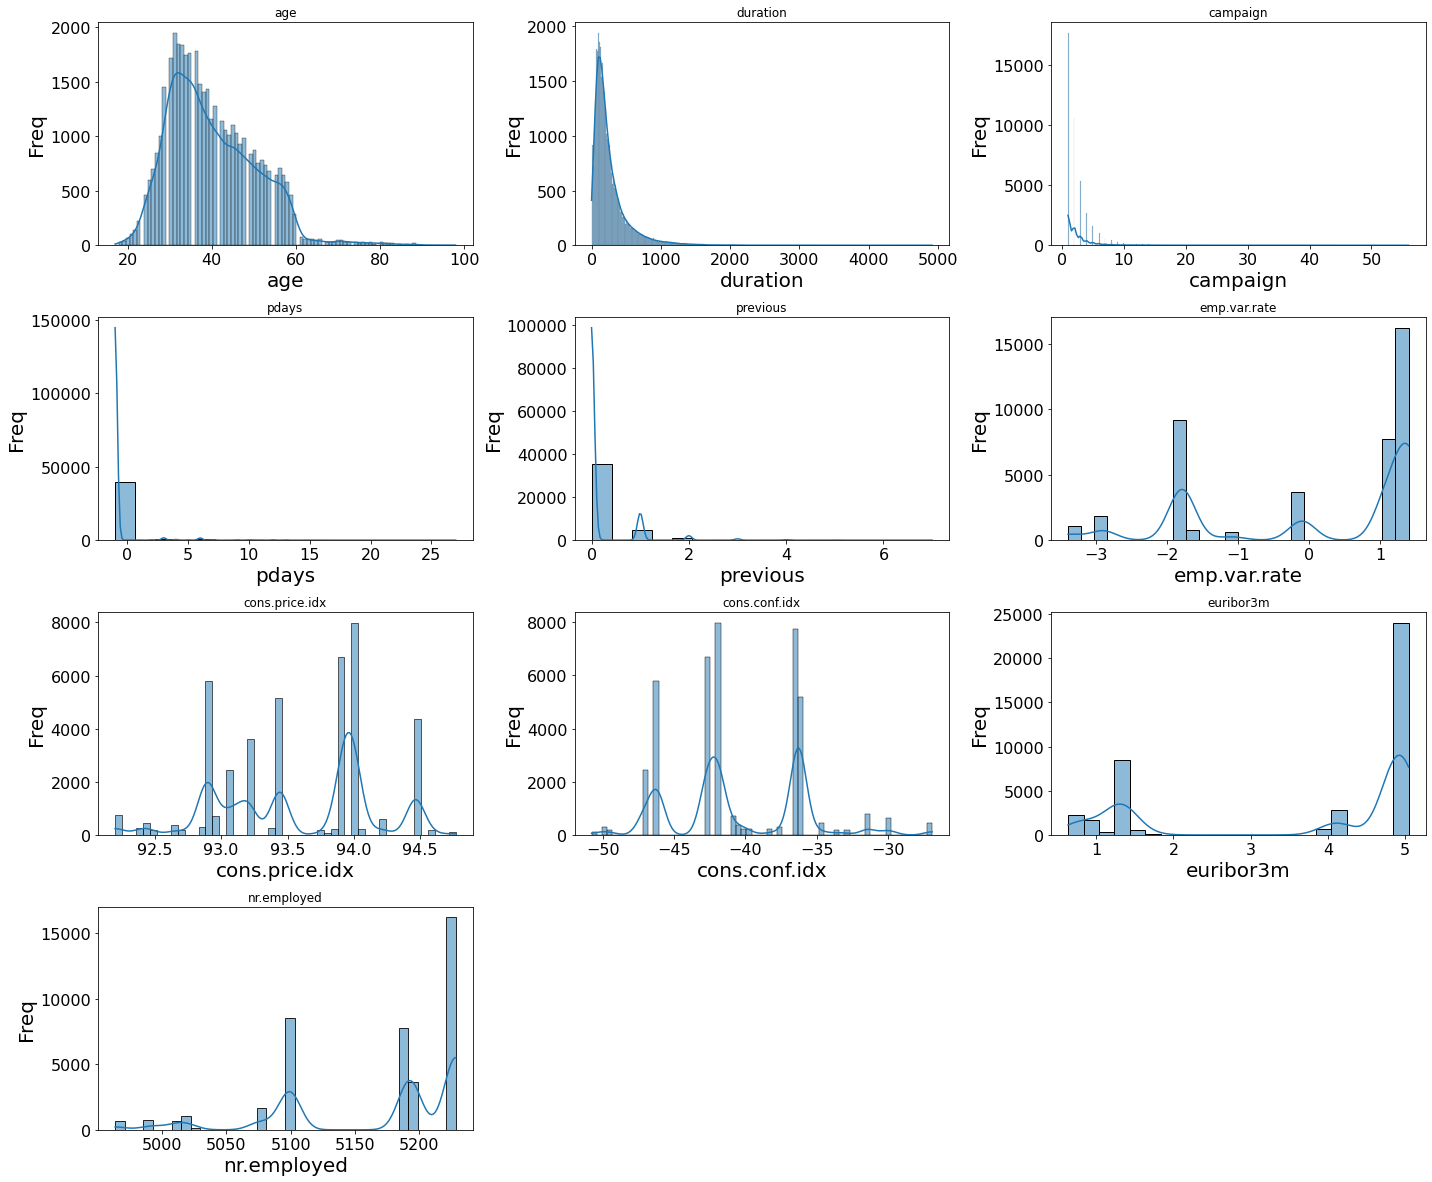

In [54]:
plt.figure(figsize=(20, 20))
for i in range(len(num_col)):
    plt.subplot(len(num_col)//2, 3, i+1)
    ax = sns.histplot(
        data[num_col[i]],
        kde = True
    )
    ax.set_xlabel(str(num_col[i]), fontsize = 20)
    ax.set_ylabel("Freq", fontsize = 20)
    ax.tick_params(labelsize=16)
    ax.set_title(str(num_col[i]))
plt.tight_layout()
plt.show()

Persebaran dari kolom numerik, datanya rata rata tidak berdistribusi normal

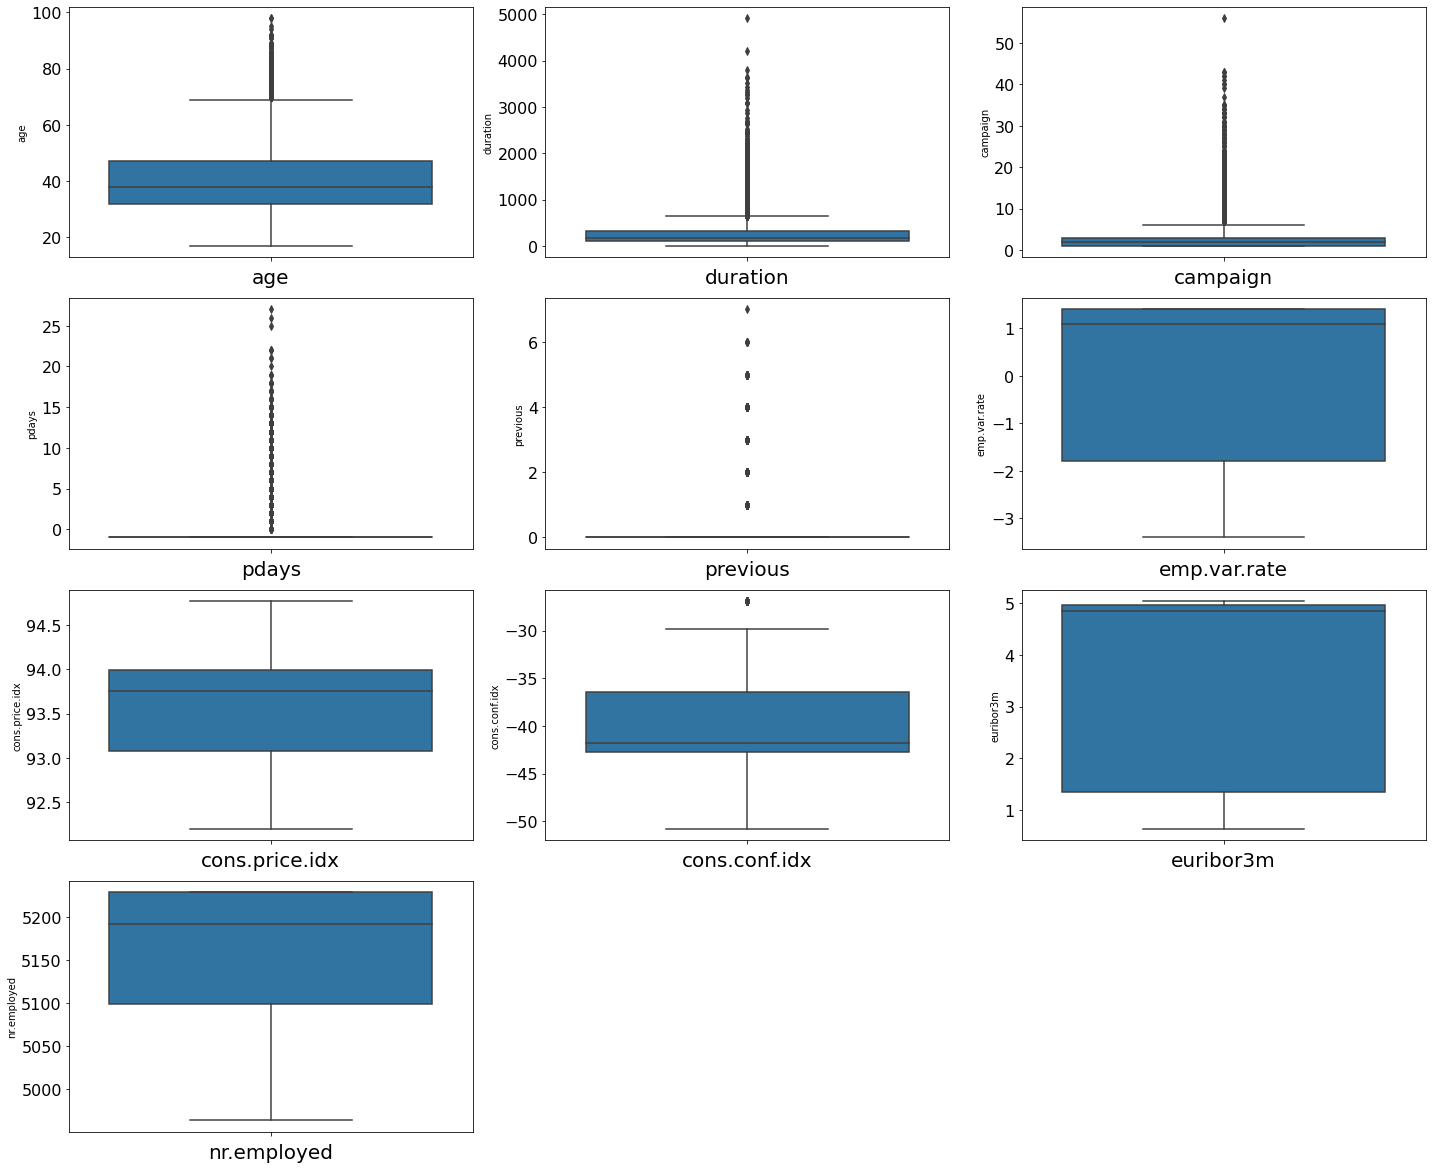

In [55]:
plt.figure(figsize=(20, 20))
for i in range(len(num_col)):
    plt.subplot(len(num_col)//2, 3, i+1)
    ax = sns.boxplot(
        y = data[num_col[i]]
        )
    ax.set_xlabel(str(num_col[i]), fontsize = 20)
    ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

Jika dilihat dari boxplot terdapat outliers dari beberapa kolom, tetapi jika dilihat dari datanya, tidak ada data yang anomali, semuanya masih masuk akal sehingga saya tidak melakukan handling outliers

In [56]:
num_col

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [57]:
data["y"] = data["y"].apply(lambda x: 1 if x == "yes" else 0)

In [58]:
num_col = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

#### Korelasi

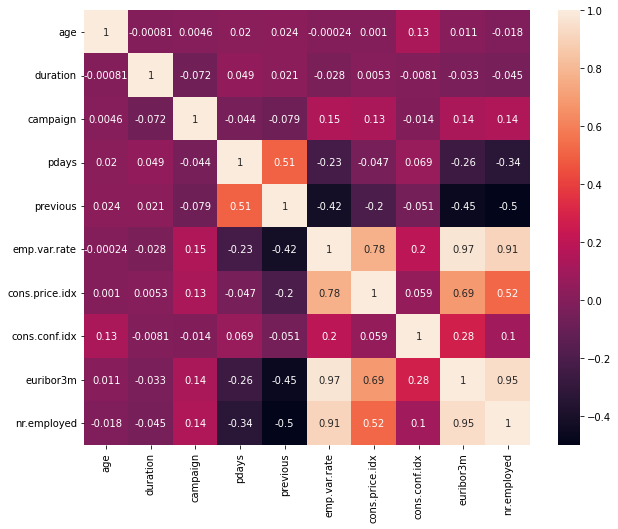

In [59]:
plt.figure(figsize = (10, 8))
sns.heatmap(
    data[num_col].corr(),
    annot = True)

Sekilas, jika dilihat dari heatmap, terdapat kolom yang memiliki multicolinearity, yaitu emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m dan nr.employed

In [60]:
num_col1 = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed', 'y']

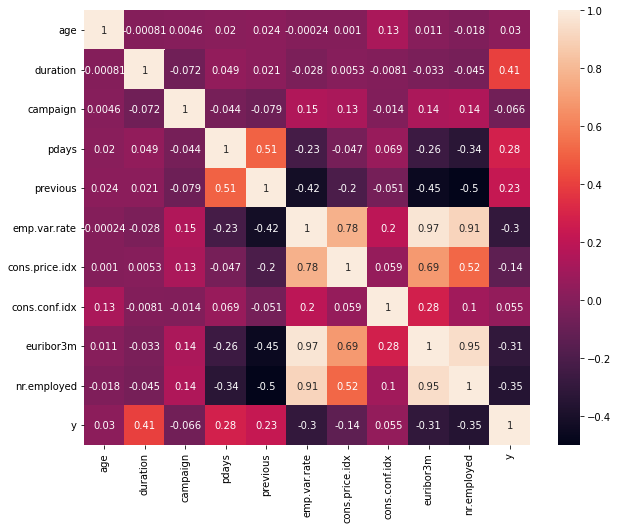

In [61]:
plt.figure(figsize = (10, 8))
sns.heatmap(
    data[num_col1].corr(),
    annot = True)

#### Multicolinearity

Disini saya melakukan pengecekan multicolinearity, dimana untuk penentuan feature data diinginkan feature tersebut bersifat independen

In [62]:
def calc_vif(x):
    
    viff = pd.DataFrame()
    viff['variables'] = x.columns
    viff['VIF'] = [vif(x.values, i) for i in range(x.shape[1])]
    
    return viff

In [63]:
calc_vif(data[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']])

,variables,VIF
0,age,16.048334
1,duration,2.011078
2,campaign,1.921496
3,pdays,1.754077
4,previous,1.810264
5,emp.var.rate,28.955180
6,cons.price.idx,22652.449181
7,cons.conf.idx,119.601823
8,euribor3m,226.409701
9,nr.employed,26606.046299


Menghapus kolom yang memiliki nilai multicolinearity lebih dari 20

In [64]:
calc_vif(data[['age', 'duration', 'campaign', 'pdays', 'previous']])

,variables,VIF
0,age,3.255784
1,duration,1.876337
2,campaign,1.778228
3,pdays,1.607175
4,previous,1.476362


Kolom yang memiliki nilai multicolinearity rendah

In [65]:
col_multicol = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']

In [66]:
data.drop(columns=col_multicol, inplace=True)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,0
1,57,services,married,high school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,0
2,37,services,married,high school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,0
3,40,admin,married,basic 6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,0
4,56,services,married,high school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,0


### Modeling

In [67]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,0
1,57,services,married,high school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,0
2,37,services,married,high school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,0
3,40,admin,married,basic 6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,0
4,56,services,married,high school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,0


In [68]:
X = data.drop(['y'], axis=1)
y = data['y']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 9)

In [70]:
logreg = LogisticRegression(random_state=9)
m_svm = SVC(random_state=9, probability=True)
knn = KNeighborsClassifier()
naive = GaussianNB()
rfc = RandomForestClassifier(random_state=9)
dtc = DecisionTreeClassifier(random_state=9)
ada = AdaBoostClassifier(random_state=9)

In [71]:
numerical_pipeline = Pipeline([
    ('scale', StandardScaler())
])

onehot_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
    ('onehot', OneHotEncoder(drop='first'))
])
ord_pipeline = Pipeline([
    ('ord', OrdinalEncoder())
])

ordinal_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
    ('ordinal', OrdinalEncoder())
])

transformer = ColumnTransformer([
    ('num_pipe', numerical_pipeline, 'age duration campaign pdays previous'.split()),
    ('onehot_pipe', onehot_pipeline, ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']),
    ('ord_pipe', ord_pipeline, ['month', 'day_of_week']),
    ('ordinal_pipe', ordinal_pipeline, ['education'])
], remainder='passthrough')

Disini saya membuat pipeline untuk proses scalling, SimpleImputer, one hot encoding dan ordinal encoder

#### Logistic Regression

In [72]:
logreg_pipe = Pipeline([
    ('transformer', transformer),
    ('logreg', logreg)
])

In [73]:
logreg_pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [74]:
y_pred = logreg_pipe.predict(X_test)
print("LOGREG Test Score: ", logreg_pipe.score(X_test, y_test))

LOGREG Test Score:  0.9045653229723166


In [75]:
print("LOGREG Train Score: ", logreg_pipe.score(X_train, y_train))

LOGREG Train Score:  0.9056162720097146


In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7308
           1       0.65      0.33      0.43       928

    accuracy                           0.90      8236
   macro avg       0.79      0.65      0.69      8236
weighted avg       0.89      0.90      0.89      8236



In [77]:
logreg_score = cross_val_score(logreg_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('Logistic Regression Val ROC_AUC Score:', logreg_score.mean(), "STD: ", logreg_score.std())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Logistic Regression Val ROC_AUC Score: 0.8884052736593867 STD:  0.004327497792933497


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


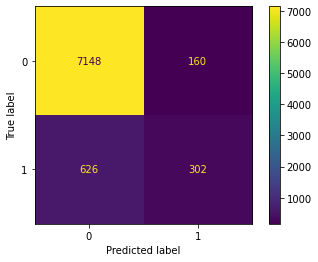

In [78]:
plot_confusion_matrix(logreg_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


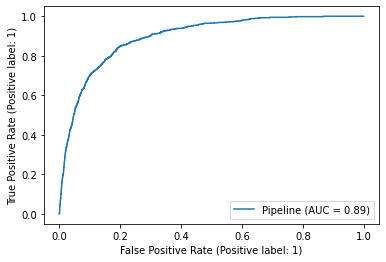

In [79]:
plot_roc_curve(logreg_pipe, X_test, y_test)

#### SVM

In [80]:
svm_pipe = Pipeline([
    ('transformer', transformer),
    ('svm', m_svm)
])

In [81]:
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [82]:
y_pred = svm_pipe.predict(X_test)
print("SVM Test Score: ", svm_pipe.score(X_test, y_test))
print("SVM Train Score: ", svm_pipe.score(X_train, y_train))

SVM Test Score:  0.9015298688683827
SVM Train Score:  0.9040680024286581


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7308
           1       0.66      0.26      0.37       928

    accuracy                           0.90      8236
   macro avg       0.79      0.62      0.66      8236
weighted avg       0.88      0.90      0.88      8236



In [84]:
svm_score = cross_val_score(svm_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('SVM Val Score:', svm_score.mean(), "STD: ", svm_score.std())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


SVM Val Score: 0.8567277687382571 STD:  0.007139168189191073


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.8min finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


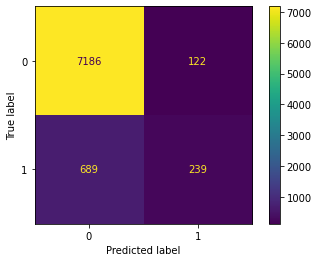

In [85]:
plot_confusion_matrix(svm_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


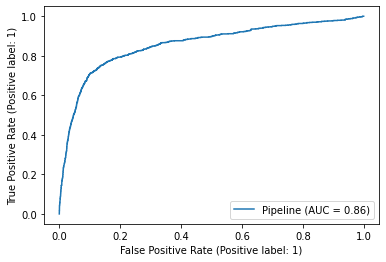

In [86]:
plot_roc_curve(svm_pipe, X_test, y_test)

#### K-Nearest Neighbor

In [87]:
knn_pipe = Pipeline([
    ('transformer', transformer),
    ('knn', knn)
])

In [88]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [89]:
y_pred = knn_pipe.predict(X_test)
print("KNN Test Score: ", knn_pipe.score(X_test, y_test))
print("KNN Train Score: ", knn_pipe.score(X_train, y_train))

KNN Test Score:  0.9004371053909664
KNN Train Score:  0.9238919247115969


In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7308
           1       0.60      0.34      0.43       928

    accuracy                           0.90      8236
   macro avg       0.76      0.65      0.69      8236
weighted avg       0.88      0.90      0.89      8236



In [91]:
knn_score = cross_val_score(knn_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('KNN Val Score:', knn_score.mean(), "STD: ", knn_score.std())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KNN Val Score: 0.8283055731514105 STD:  0.007365688246736436


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


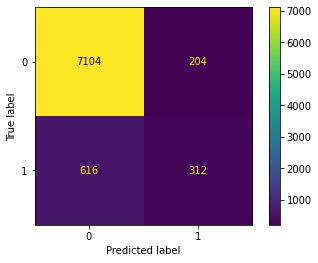

In [92]:
plot_confusion_matrix(knn_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


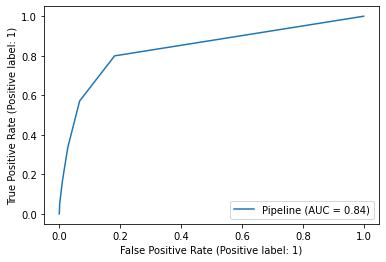

In [93]:
plot_roc_curve(knn_pipe, X_test, y_test)

#### Naive Bayes

In [94]:
naive_pipe = Pipeline([
    ('transformer', transformer),
    ('naive', naive)
])

In [95]:
naive_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7308
           1       0.60      0.34      0.43       928

    accuracy                           0.90      8236
   macro avg       0.76      0.65      0.69      8236
weighted avg       0.88      0.90      0.89      8236



In [97]:
y_pred = naive_pipe.predict(X_test)
print("NB Test Score: ", naive_pipe.score(X_test, y_test))
print("NB Train Score: ", naive_pipe.score(X_train, y_train))

NB Test Score:  0.7956532297231665
NB Train Score:  0.7919247115968427


In [98]:
naive_score = cross_val_score(naive_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('KNN Val Score:', naive_score.mean(), "STD: ", naive_score.std())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KNN Val Score: 0.8139313116056879 STD:  0.00752585943627562


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


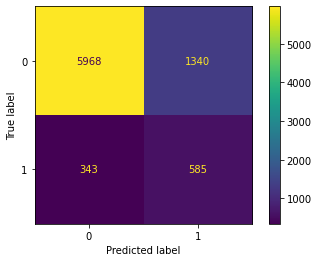

In [99]:
plot_confusion_matrix(naive_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


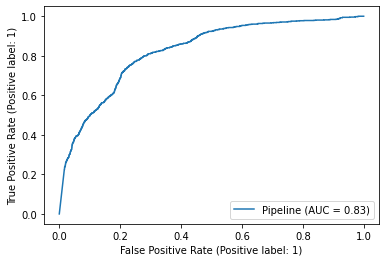

In [100]:
plot_roc_curve(naive_pipe, X_test, y_test)

#### Ada Boost

In [101]:
ada_pipe = Pipeline([
    ('transformer', transformer),
    ('ada', ada)
])

In [102]:
ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [103]:
y_pred = ada_pipe.predict(X_test)
print("ADA Test Score: ", ada_pipe.score(X_test, y_test))
print("ADA Train Score: ", ada_pipe.score(X_train, y_train))

ADA Test Score:  0.9015298688683827
ADA Train Score:  0.9048876745598057


In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7308
           1       0.61      0.36      0.45       928

    accuracy                           0.90      8236
   macro avg       0.76      0.67      0.70      8236
weighted avg       0.89      0.90      0.89      8236



In [105]:
ada_score = cross_val_score(ada_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('ADA Val Score:', ada_score.mean(), "STD: ", ada_score.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ADA Val Score: 0.9107199181081693 STD:  0.004904447792304188


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


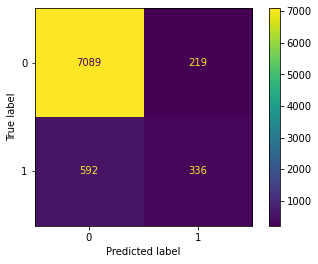

In [106]:
plot_confusion_matrix(ada_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


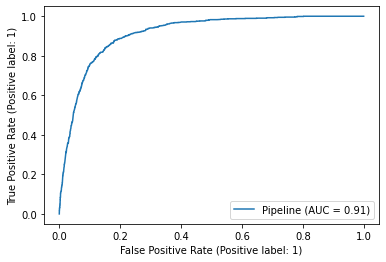

In [107]:
plot_roc_curve(ada_pipe, X_test, y_test)

#### Decision Tree

In [108]:
dtc_pipe = Pipeline([
    ('transformer', transformer),
    ('dtc', dtc)
])

In [109]:
dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [110]:
y_pred = dtc_pipe.predict(X_test)
print("DTC Test Score: ", dtc_pipe.score(X_test, y_test))
print("DTC Train Score: ", dtc_pipe.score(X_train, y_train))

DTC Test Score:  0.8801602719766877
DTC Train Score:  1.0


In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7308
           1       0.47      0.50      0.49       928

    accuracy                           0.88      8236
   macro avg       0.70      0.72      0.71      8236
weighted avg       0.88      0.88      0.88      8236



In [112]:
dtc_score = cross_val_score(dtc_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('DTC Val Score:', dtc_score.mean(), "STD: ", dtc_score.std())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DTC Val Score: 0.6952094287135048 STD:  0.00748074894929694


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


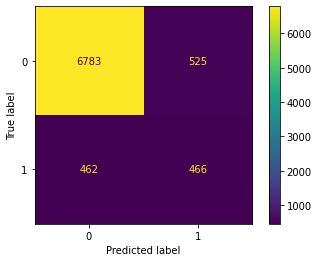

In [113]:
plot_confusion_matrix(dtc_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


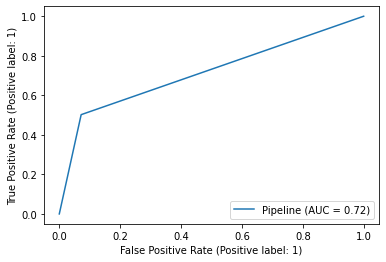

In [114]:
plot_roc_curve(dtc_pipe, X_test, y_test)

#### Random Forest

In [115]:
rfc_pipe = Pipeline([
    ('transformer', transformer),
    ('rfc', rfc)
])

In [116]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                    

In [117]:
y_pred = rfc_pipe.predict(X_test)
print("RFC Test Score: ", rfc_pipe.score(X_test, y_test))
print("RFC Train Score: ", rfc_pipe.score(X_train, y_train))

RFC Test Score:  0.9060223409422049
RFC Train Score:  0.9999696417729205


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7308
           1       0.64      0.39      0.48       928

    accuracy                           0.91      8236
   macro avg       0.78      0.68      0.72      8236
weighted avg       0.89      0.91      0.90      8236



In [119]:
rfc_score = cross_val_score(rfc_pipe, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
print('RFC Val Score:', rfc_score.mean(), "STD: ", rfc_score.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RFC Val Score: 0.9165100485372294 STD:  0.0036119644923071274


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


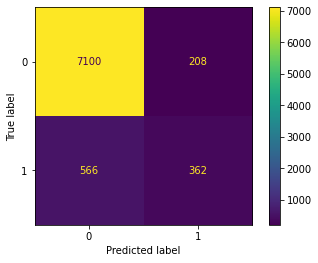

In [120]:
plot_confusion_matrix(rfc_pipe, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


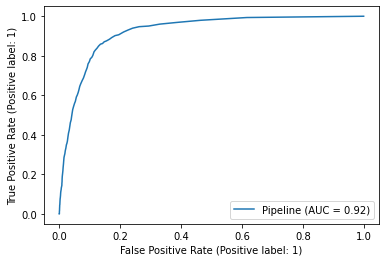

In [121]:
plot_roc_curve(rfc_pipe, X_test, y_test)

In [122]:
ls = logreg_score.mean()
sv = svm_score.mean()
kncs = knn_score.mean()
nav = naive_score.mean()
ad = ada_score.mean()
dtcs = dtc_score.mean()
rfcs = rfc_score.mean()
df = pd.DataFrame({'Logistic Regression': [ls], 'SVM': [sv], 'KNearest Neighbors': [kncs], 'Naive Bayes': [nav], 'Ada Boost': [ad], 'Decision Tree CV Score': [dtcs], 'Random Forest CV Score': [rfcs]})
df

,Logistic Regression,SVM,KNearest Neighbors,Naive Bayes,Ada Boost,Decision Tree CV Score,Random Forest CV Score
0,0.888405,0.856728,0.828306,0.813931,0.91072,0.695209,0.91651


Dari evaluasi model dengan menggunakan roc_auc score, tanpa melakukan hyperparameter tuning, nilai random forest dan ada boost lebih baik dibandingkan dengan model lain, dan Decision Tree lebih kecil

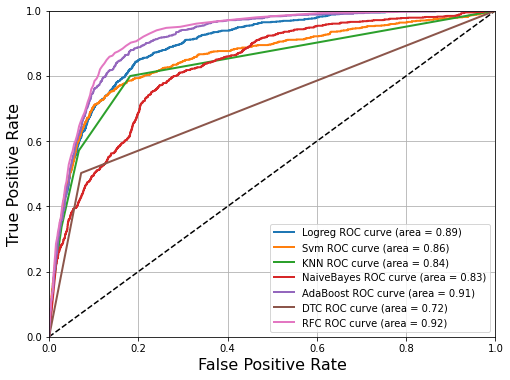

In [123]:
plt.figure(figsize=(8, 6))                                    
plt.axis([0, 1, 0, 1])                                    
plt.xlabel('False Positive Rate', fontsize=16) 
plt.ylabel('True Positive Rate', fontsize=16)    
plt.grid(True)                                            
plt.plot([0, 1], [0, 1], 'k--')
labels=['Logreg','Svm','KNN', 'NaiveBayes','AdaBoost', 'DTC', 'RFC']
for idx,model in enumerate([logreg_pipe, svm_pipe, knn_pipe , naive_pipe, ada_pipe, dtc_pipe, rfc_pipe]):
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=labels[idx] + ' ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right",prop={'size': 10})

Dari Grafik ROC-AUC juga model random forest memiliki nilai TPR yang lebih baik, berdasarkan nilai f1 score DTC memiliki nilai paling baik

## Hyperparameter Tuning

#### Logistic Regression

In [124]:
logreg_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'logreg', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pi

In [125]:
logreg_param = {'logreg__solver': ["newton-cg", "liblinear"], 
             'logreg__penalty': ["l1", "l2"], 
             'logreg__C': [10, 1, 0.1]}

logreg_tuned = GridSearchCV(estimator=logreg_pipe,
                          param_grid=logreg_param, 
                          cv=5,
                          n_jobs=-1,
                          scoring='roc_auc',
                          verbose=1
                          )

In [126]:
logreg_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [127]:
logreg_tuned.best_params_

{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}

In [128]:
logreg_tuned.best_score_

0.8886144360149648

In [129]:
logreg_tun = logreg_tuned.best_estimator_

In [130]:
logreg_tuned_score = cross_val_score(logreg_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
logreg_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


0.8886144360149648

In [131]:
y_pred = logreg_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7308
           1       0.66      0.32      0.43       928

    accuracy                           0.90      8236
   macro avg       0.79      0.65      0.69      8236
weighted avg       0.89      0.90      0.89      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


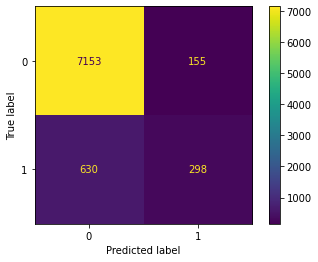

In [132]:
plot_confusion_matrix(logreg_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


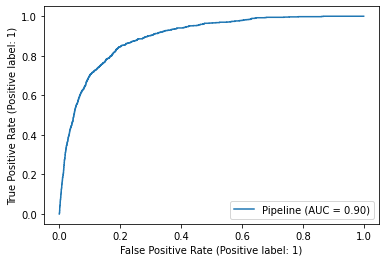

In [133]:
plot_roc_curve(logreg_tun, X_test, y_test)

#### SVM

In [134]:
svm_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'svm', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pipe_

In [135]:
 svm_param = {'svm__kernel': ["linear", "poly"], 
              'svm__gamma': [0.1], 
              'svm__C': [0.1]}

 svm_tuned = GridSearchCV(estimator=svm_pipe,
                           param_grid=svm_param, 
                           cv=5,
                           n_jobs=-1,
                           scoring='roc_auc',
                           verbose=1
                           )

In [136]:
svm_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [137]:
svm_tuned.best_score_

0.8536220600351652

In [138]:
svm_tun = svm_tuned.best_estimator_

In [139]:
svm_tuned_score = cross_val_score(svm_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
svm_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


0.8536220600351652

In [140]:
y_pred = svm_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7308
           1       0.65      0.20      0.31       928

    accuracy                           0.90      8236
   macro avg       0.78      0.59      0.63      8236
weighted avg       0.88      0.90      0.87      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


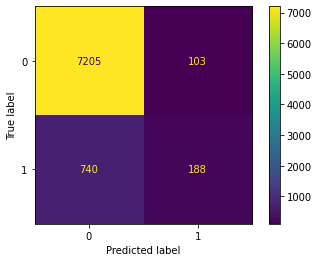

In [141]:
plot_confusion_matrix(svm_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


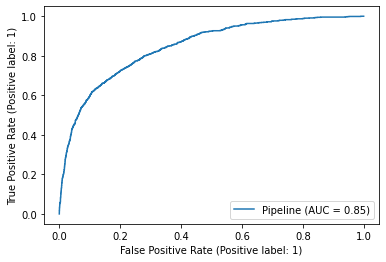

In [142]:
plot_roc_curve(svm_tun, X_test, y_test)

#### K-Nearest Neighbor

In [143]:
knn_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'knn', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pipe_

In [144]:
knn_param = {'knn__n_neighbors': [3, 5, 10], 
             'knn__p': [1,2]}

knn_tuned = GridSearchCV(estimator=knn_pipe,
                          param_grid=knn_param, 
                          cv=5,
                          n_jobs=-1,
                          scoring='roc_auc',
                          verbose=1
                          )

In [145]:
knn_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [146]:
knn_tuned.best_score_

0.8671592999820454

In [147]:
knn_tun = knn_tuned.best_estimator_

In [148]:
knn_tuned_score = cross_val_score(knn_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
knn_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


0.8671592999820454

In [149]:
y_pred = knn_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7308
           1       0.64      0.26      0.37       928

    accuracy                           0.90      8236
   macro avg       0.78      0.62      0.66      8236
weighted avg       0.88      0.90      0.88      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


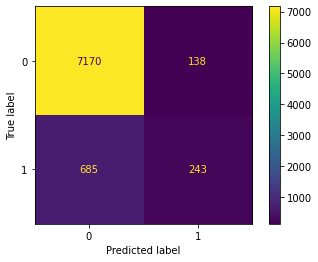

In [150]:
plot_confusion_matrix(knn_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


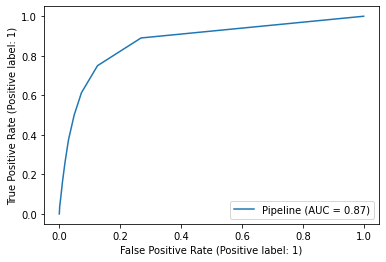

In [151]:
plot_roc_curve(knn_tun, X_test, y_test)

#### Naive Bayes

In [152]:
naive_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'naive', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pip

In [153]:
 naive_param = {'naive__var_smoothing': np.logspace(0,-9, num=10)
              }

 naive_tuned = GridSearchCV(estimator=naive_pipe,
                           param_grid=naive_param, 
                           cv=5,
                           n_jobs=-1,
                           scoring='roc_auc',
                           verbose=1
                           )

In [154]:
naive_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [155]:
naive_tuned.best_score_

0.8662196271292014

In [156]:
naive_tun = naive_tuned.best_estimator_

In [157]:
naive_tuned_score = cross_val_score(naive_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
naive_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


0.8662196271292014

In [158]:
y_pred = naive_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.67      0.06      0.11       928

    accuracy                           0.89      8236
   macro avg       0.78      0.53      0.52      8236
weighted avg       0.87      0.89      0.85      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


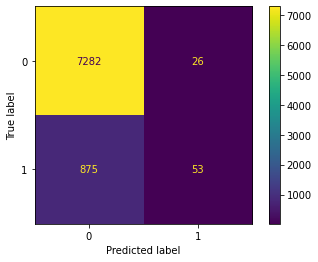

In [159]:
plot_confusion_matrix(naive_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


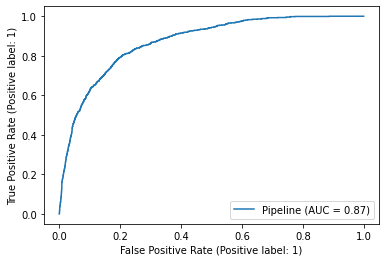

In [160]:
plot_roc_curve(naive_tun, X_test, y_test)

#### Ada Boost

In [161]:
ada_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'ada', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pipe_

In [162]:
ada_param = {'ada__learning_rate': [0.1, 1],
               'ada__n_estimators': [10, 40],
               'ada__random_state': [9]
              }

ada_tuned = GridSearchCV(estimator=ada_pipe,
                           param_grid=ada_param, 
                           cv=5,
                           n_jobs=-1,
                           scoring='roc_auc',
                           verbose=1
                           )

In [163]:
ada_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [164]:
ada_tuned.best_score_

0.9081685259484932

In [165]:
ada_tun = ada_tuned.best_estimator_

In [166]:
ada_tuned_score = cross_val_score(ada_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
ada_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


0.9081685259484932

In [167]:
y_pred = ada_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7308
           1       0.61      0.34      0.44       928

    accuracy                           0.90      8236
   macro avg       0.77      0.66      0.69      8236
weighted avg       0.89      0.90      0.89      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


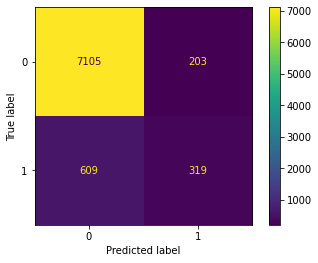

In [168]:
plot_confusion_matrix(ada_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


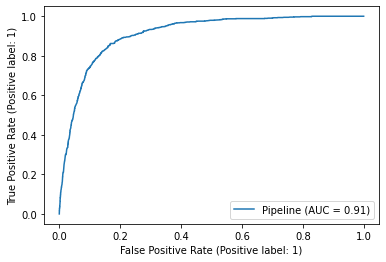

In [169]:
plot_roc_curve(ada_tun, X_test, y_test)

#### Decision Tree

In [170]:
dtc_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'dtc', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pipe_

In [171]:
dtc_param = {
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth':[5,10,15,20,25,30],
    'dtc__min_samples_split':[2,5,10],
    'dtc__min_samples_leaf':[1,2,5,7],
}

dtc_tuned = GridSearchCV(estimator=dtc_pipe, 
                            param_grid=dtc_param, 
                            cv=5, 
                            n_jobs=-1, 
                            scoring='roc_auc',
                           verbose=1)

In [172]:
dtc_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [173]:
dtc_tuned.best_score_

0.8806850372372692

In [174]:
dtc_tun = dtc_tuned.best_estimator_

In [175]:
dtc_tuned_score = cross_val_score(dtc_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
dtc_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


0.8806850372372692

In [176]:
y_pred = dtc_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7308
           1       0.60      0.40      0.48       928

    accuracy                           0.90      8236
   macro avg       0.76      0.68      0.71      8236
weighted avg       0.89      0.90      0.89      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


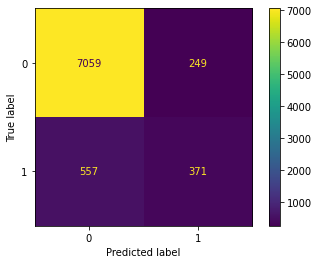

In [177]:
plot_confusion_matrix(dtc_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


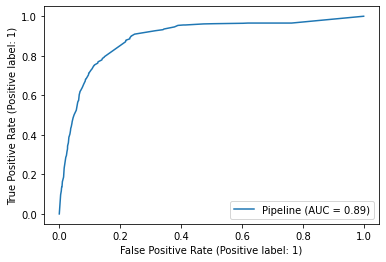

In [178]:
plot_roc_curve(dtc_tun, X_test, y_test)

#### Random Forest

In [179]:
rfc_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'rfc', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__num_pipe', 'transformer__onehot_pipe', 'transformer__ord_pipe', 'transformer__ordinal_pipe', 'transformer__num_pipe__memory', 'transformer__num_pipe__steps', 'transformer__num_pipe__verbose', 'transformer__num_pipe__scale', 'transformer__num_pipe__scale__copy', 'transformer__num_pipe__scale__with_mean', 'transformer__num_pipe__scale__with_std', 'transformer__onehot_pipe__memory', 'transformer__onehot_pipe__steps', 'transformer__onehot_pipe__verbose', 'transformer__onehot_pipe__impute_cat', 'transformer__onehot_pipe__onehot', 'transformer__onehot_pipe__impute_cat__add_indicator', 'transformer__onehot_pipe__impute_cat__copy', 'transformer__onehot_pipe__impute_cat__fill_value', 'transformer__onehot_pipe_

In [180]:
rfc_param = {'rfc__n_estimators': [50, 100],
            'rfc__max_depth': [10, 50],
            'rfc__min_samples_split': [2],
            'rfc__max_features': ['auto', 'sqrt'],
            'rfc__min_samples_leaf' : [4]
           }


rfc_tuned = GridSearchCV(estimator=rfc_pipe, 
                            param_grid=rfc_param, 
                            cv=5, 
                            n_jobs=-1, 
                            scoring='roc_auc',
                           verbose=1)

In [181]:
rfc_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('onehot_pipe',
                                    

In [182]:
rfc_tuned.best_score_

0.9227339900823569

In [183]:
rfc_tun = rfc_tuned.best_estimator_

In [184]:
rfc_tuned_score = cross_val_score(rfc_tun, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
rfc_tuned_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


0.9227339900823569

In [185]:
y_pred = rfc_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7308
           1       0.66      0.38      0.48       928

    accuracy                           0.91      8236
   macro avg       0.79      0.68      0.71      8236
weighted avg       0.89      0.91      0.90      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


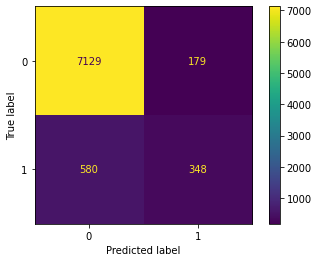

In [186]:
plot_confusion_matrix(rfc_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


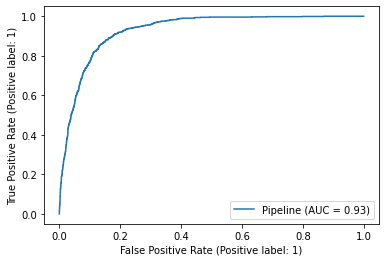

In [187]:
plot_roc_curve(rfc_tun, X_test, y_test)

In [188]:
lst = logreg_tuned_score.mean()
svt = svm_tuned_score.mean()
kncst = knn_tuned_score.mean()
navt = naive_tuned_score.mean()
adt = ada_tuned_score.mean()
dtcst = dtc_tuned_score.mean()
rfcst = rfc_tuned_score.mean()
dft = pd.DataFrame({'Logistic Regression': [lst], 'SVM': [svt], 'KNearest Neighbors': [kncst], 'Naive Bayes': [navt], 'Ada Boost': [adt], 'Decision Tree CV Score': [dtcst], 'Random Forest CV Score': [rfcst]})
dft

,Logistic Regression,SVM,KNearest Neighbors,Naive Bayes,Ada Boost,Decision Tree CV Score,Random Forest CV Score
0,0.888614,0.853622,0.867159,0.86622,0.908169,0.880685,0.922734


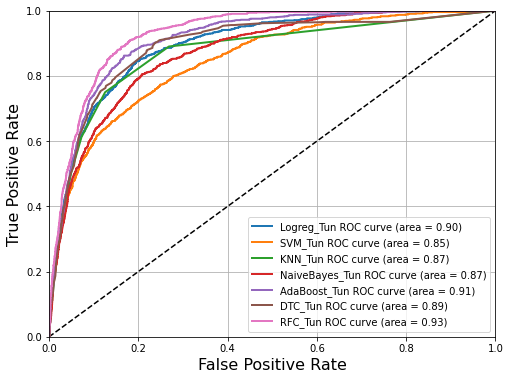

In [189]:
plt.figure(figsize=(8, 6))                                    
plt.axis([0, 1, 0, 1])                                    
plt.xlabel('False Positive Rate', fontsize=16) 
plt.ylabel('True Positive Rate', fontsize=16)    
plt.grid(True)                                            
plt.plot([0, 1], [0, 1], 'k--')

labels=['Logreg_Tun','SVM_Tun','KNN_Tun', 'NaiveBayes_Tun','AdaBoost_Tun', 'DTC_Tun', 'RFC_Tun']
for idx,model in enumerate([logreg_tun, svm_tun, knn_tun , naive_tun, ada_tun, dtc_tun, rfc_tun]):
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=labels[idx] + ' ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right", prop={'size': 10})

In [190]:
cc = {
    'Before Tuned' : [ls, sv, kncs, nav, ad, dtcs, rfcs],
    'After Tuned': [lst, svt, kncst, navt, adt, dtcst, rfcst]
}

_score = pd.DataFrame(data=cc, index=['Logistig Regression', "SVM", 'KNN', 'Naive Bayes', 'Ada Boost', 'DTC', 'RFC'])
_score


,Before Tuned,After Tuned
Logistig Regression,0.888405,0.888614
SVM,0.856728,0.853622
KNN,0.828306,0.867159
Naive Bayes,0.813931,0.866220
Ada Boost,0.910720,0.908169
DTC,0.695209,0.880685
RFC,0.916510,0.922734


Dilihat dari perbandingan beberapa model ini, dilakukan 2 perbandingan, tanpa hyperparameter tuning dan dengan hyperparameter tuning, tanpa hyperparameter tuning, didapatkan nilai roc_auc score dari logistic regression adalah 0.888405, SVM adalah 0.856728	, KNN adalah 0.828306	, Naive bayes adalah 0.813931	, Ada Boost adalah 0.910720	, DTC adalah 0.695209	, dan RFC adalah 0.916510	, 
setelah dilakukan hyperparameter tuning, nilai dari model logistic regression adalah 0.888614, SVM adalah 0.853622, KNN adalah 0.867159, Naive bayes adalah 0.866220, Ada Boost adalah 0.908169, DTC adalah 0.880685, dan RFC adalah 0.922734.

terlihat bahwa beberapa model seperti logistic regression, KNN, Naive Bayes, DTC dan RFC mengalami kenaikan score setelah dilakukan hyperparameter tuning, sedangkan SVM, Ada Boost saat dilakukan hyperparameter tuning mengalami penurunan score ROC AUC, sehingga kedua model ini untuk kasus dataset seperti ini lebih baik tidak dilakukan hyperparameter tunning, dan model Random Forest setelah dilakukan Hyperparameter tuning merupakan Model yang terbaik jika dilihat dari score ROC AUC dan dari grafik ROC AUC ini

Dari nilai precision juga model RFC ini memiliki nilai yg cukup bagus dengan nilai recall yang tidak terlalu menurun dari model lainya, jika dilihat model naive bayes memiliki score precision yang lebih bagus namun nilai recall menjadi sangat kecil, sehingga RFC ini memiliki overall score yang lebih baik, walaupun nilai f1 score tidak berbeda dengan sebelum dilakukan Hyperparameter, karena disini saya ingin menekan nilai False Positif maka fokus di score Precision yg baik dengan recall yang tidak terlalu jelek

## Model Inference

Berdasarkan yang sudah dijelaskan diatas, model terbaik yaitu RFC yang telah di Hyperparameter

In [191]:
y_pred = rfc_tun.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7308
           1       0.66      0.38      0.48       928

    accuracy                           0.91      8236
   macro avg       0.79      0.68      0.71      8236
weighted avg       0.89      0.91      0.90      8236



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


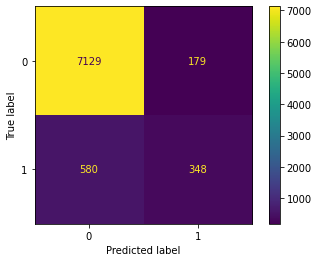

In [192]:
plot_confusion_matrix(rfc_tun, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


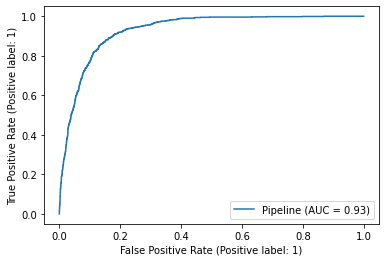

In [193]:
plot_roc_curve(rfc_tun, X_test, y_test)

Model RFC tuned ini memiliki nilai precision 0.66 dan recall 0.38, lebih baik daripada model lain karena disini saya fokus menekan kelas FP sehingga precision score yang saya lihat, dengan nilai recall yang tidak terlalu kecil, dari confussion metrics, terdapat 179 data yang masuk ke kelas False Positif, pada grafik ROC-AUC juga model ini memiliki nilai yang baik

### Data Predict

In [194]:
pred = pd.DataFrame([{
    'age': 32,
    'job': 'admin',
    'marital': 'single',
    'education': 'university degree',
    'default' : 'no',
    'housing': 'no',
    'loan': 'no',
    'contact': 'cellular',
    'month': 'jun',
    'day_of_week': 'mon',
    'duration': 300,
    'campaign': 1,
    'pdays' : 2,
    'previous': 0,
    'poutcome': 'nonexistent'

}], index=[0])

In [195]:
result = rfc_tun.predict(pred)
if result == 0:
    print('No Subscribe')
else:
    print('Subscribe')

Subscribe


In [196]:
rfc_test_p = rfc_tun.predict(X_test)

dd = pd.DataFrame({'actual':y_test, 'predict':rfc_test_p
})
dd

,actual,predict
1727,0,0
16053,1,0
27103,0,0
1473,0,0
2930,0,0
...,...,...
15305,0,0
32179,0,0
27390,0,0
13335,0,0


## Kesimpulan


EDA
- Dari beberapa pekerjaan client, admin paling banyak untuk berlangganan deposit, jika dilihat keseluruhan, pekerjaan dengan penghasilan yang "tetap" lebih berpotensi untuk berlangganan daripada pekerjaan dengan penghasilan yang tidak tetap seperti ibu rumah tangga, pensiunan, self employed dll
- Status dari clien yang menikah lebih banyak berlangganan deposit, tetapi untuk client yang single juga berpotensi untuk berlangganan
- Client lulusan Universitas lebih banyak berlangganan deposit.
- Client yang tidak memiliki kartu kredit, lebih banyak berlangganan deposit, mungkin bisa jadi pembayaran kartu kredit ini menghambat seseorang untuk berlangganan deposit
- Client yang tidak memiliki Pinjaman lebih berpotensi untuk berlangganan, dan yang memiliki cicilan rumah juga berpotensi untuk berlangganan deposit
- Client yang dihubungi kebanyakan berumur 24 - 60 tahun, dimana yang berpotensi untuk berlangganan deposit berada di umur 24-45 tahun
- Client yang banyak berlangganan biasanya belum dihubungi atau belum ditawari deposit dari campaign sebelumnya
- biasanya client dihubungi sekitar 90-150 detik, jika dilihat dari peta persebaran, makin lama durasi meneleponya maka biasanya client akan berlangganan, dengan durasi yang lama ini maka penjelasan keuntungan berlangganan deposit akan lebih jelas, sehingga dapat menarik minat client untuk berlangganan deposit

Modelling
- Dilakukan perbandingan beberapa model
- Dari evaluasi model default dengan menggunakan roc_auc score, nilai random forest dan ada boost lebih baik dibandingkan dengan model lain, dan Decision Tree lebih kecil, sedangkan dilihat dari nilai F1, model DTC lebih baik dibandingkan model lain
- Dari Grafik ROC-AUC juga model random forest memiliki nilai TPR yang lebih baik
- Setelah dilakukan Hyperparameter Tuning, beberapa model seperti logistic regression, KNN, Naive Bayes, DTC dan RFC mengalami kenaikan score setelah dilakukan hyperparameter tuning, sedangkan SVM, Ada Boost saat dilakukan hyperparameter tuning mengalami penurunan score ROC AUC.
- Dari nilai precision juga model RFC ini memiliki nilai yg cukup bagus dengan nilai recall yang tidak terlalu menurun dari model lainya, jika dilihat model naive bayes memiliki score precision yang lebih bagus namun nilai recall menjadi sangat kecil, sehingga RFC ini memiliki overall score yang lebih baik, walaupun nilai f1 score tidak berbeda dengan sebelum dilakukan Hyperparameter, karena disini saya ingin menekan nilai False Positif maka fokus di score Precision yg baik dengan recall yang tidak terlalu jelek
- Model Random Forest dengan Hyperparameter Tuning ini merupakan data yang paling baik di kasus ini

In [202]:
# rfc_tun.steps[1][1].feature_importances_